# Data and Imports

In [1]:



import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache")
set_global("dataloader_workers", 4)
set_global("use_autocast", True)
set_global("models_dir", "/home/ahemf/cache/")

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device, my_collate
get_global("cache_dir")
from facebook_hateful_memes_detector.models import Fasttext1DCNNModel, MultiImageMultiTextAttentionEarlyFusionModel, LangFeaturesModel, AlbertClassifer
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
reload(facebook_hateful_memes_detector)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)
device


device(type='cuda')

- What Augs are useful
- What Text models perform best

In [17]:

def get_preprocess_text():
    char_level = {"keyboard": 0.1, "char_substitute": 0.4, "char_insert": 0.2, "char_swap": 0.2, 
                  "ocr": 0.0, "char_delete": 0.1}
    char_level = TextAugment([0.1, 0.65, 0.25], char_level)
    word_level = {"fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.2,
                 "stopword_insert": 0.5, "word_join": 0.2, "word_cutout": 0.8, "gibberish_insert": 0.0}
    word_level = TextAugment([0.1, 0.65, 0.25], word_level)
    sentence_level = {"text_rotate": 0.0, "sentence_shuffle": 0.0, 
                      "one_third_cut": 0.3, "half_cut":0.0, "part_select": 0.75}
    sentence_level = TextAugment([0.55, 0.45], sentence_level)
    def process(text):
        text = sentence_level(text)
        text = word_level(text)
        text = char_level(text)
        return text
    return process


# choice_probas = {"keyboard": 0.1, "char_substitute": 0.0, "char_insert": 0.1, "char_swap": 0.1, "ocr": 0.0, "char_delete": 0.1,
#                  "fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.1,
#                  "stopword_insert": 0.3, "word_join": 0.2, "word_cutout": 0.8,
#                  "text_rotate": 0.0, "sentence_shuffle": 0.0, 
#                  "one_third_cut": 0.3, "half_cut":0.0, "part_select": 0.5}
# preprocess_text = TextAugment([0.05, 0.2, 0.2, 0.3, 0.25], choice_probas, fasttext_file="wiki-news-300d-1M-subword.bin")

# choice_probas_test = {"keyboard": 0.1, "char_substitute": 0.0, "char_insert": 0.1, "char_swap": 0.0, "char_delete": 0.2,
#                  "fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.1,
#                  "stopword_insert": 0.3, "word_join": 0.2, "word_cutout": 0.8,
#                  "text_rotate": 0.0, "sentence_shuffle": 0.0, 
#                       "one_third_cut": 0.3, "half_cut":0.0, "part_select": 0.5}

# preprocess_text_test = TextAugment([0.1, 0.9], choice_probas_test, fasttext_file="wiki-news-300d-1M-subword.bin")

preprocess_text = get_preprocess_text()
preprocess_text_test = get_preprocess_text()

data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=None, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = False, dev=False, test_dev=True,
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)


# Clean text


In [4]:
# data["train"].label.value_counts()
# train = data["train"]

# ones = train[train["label"] == 1]
# zeros = train[train["label"] == 0].sample(n=len(ones), replace=False)
# data["train"] = pd.concat((ones, zeros)).sample(frac=1.0)
# data["train"].label.value_counts()

# len(set(data["train"]["id"])) == data["train"].shape[0]


https://discuss.pytorch.org/t/how-to-implement-torch-optim-lr-scheduler-cosineannealinglr/28797/11

In [18]:


scheduler_init_fn = get_multistep_lr([11, 13], gamma=0.25) # get_cosine_schedule_with_warmup # get_cosine_with_hard_restarts_schedule_with_warmup
scheduler_init_fn = get_cosine_schedule_with_warmup()
reg_sched = get_regularizer_scheduler()



# Params

In [ ]:
sgd = torch.optim.SGD
sgd_params = dict(lr=2e-2, momentum=0.9, dampening=0, weight_decay=0, nesterov=False)

rangerQH = optim.RangerQH
rangerQHparams = dict(lr=1e-3, betas=(0.9, 0.999), nus=(.7, 1.0),
    weight_decay=0.0,
    k=6,
    alpha=.5,
    decouple_weight_decay=True,
    eps=1e-8,)

adam = torch.optim.Adam
adam_params = params=dict(lr=1e-3, weight_decay=1e-7)

adamw = torch.optim.AdamW
adamw_params = dict(lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-2)

novograd = optim.NovoGrad
novograd_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
    grad_averaging=False,
    amsgrad=False,)

qhadam = optim.QHAdam
qhadam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    nus=(1.0, 1.0),
    weight_decay=0,
    decouple_weight_decay=False,
    eps=1e-8,)

radam = optim.RAdam
radam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,)

yogi = optim.Yogi
yogi_params = dict(lr= 1e-2,
    betas=(0.9, 0.999),
    eps=1e-3,
    initial_accumulator=1e-6,
    weight_decay=0)




# BERT Models

## Non Ensemble

In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.05,
                              dropout=0.05,
                              word_masking_proba=0.1,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=1,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="cnn1d", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[1, 4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# 0.851	0.666


In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.05,
                              dropout=0.05,
                              word_masking_proba=0.1,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=1,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="cnn1d", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.05,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[1, 4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs




## Head Ensemble

In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.0,
                              dropout=0.05,
                              word_masking_proba=0.1, # 0.1
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=1,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="head_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.05,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[17, 27, 32, 37, 41, 44, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False
)
r2, p2 = results, prfs
results
prfs



## Multi-eval Head Ensemble


In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 20
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.0,
                              dropout=0.1,
                              word_masking_proba=0.1, # 0.1
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=1,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="head_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[17, 27, 32, 37, 41, 44, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=5, evaluate_in_train_mode=True
)
r2, p2 = results, prfs
results
prfs

# 0.799	0.657 gaussian_noise=0.0, dropout=0.05, word_masking_proba=0.1,
# 0.780	0.634 gaussian_noise=0.0, dropout=0.05, word_masking_proba=0.15, 
# 0.806	0.648 gaussian_noise=0.0, dropout=0.02, word_masking_proba=0.1
# 0.803	0.655 gaussian_noise=0.0, dropout=0.1, word_masking_proba=0.1, (0.807	0.657) 0.803	0.653


## Decoder Ensemble

### Train All Params

Pick stored Model /home/ahemf/cache/distilbert-nsp Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>
Autocast =  True Epochs =  48 Divisor = 2 Examples = 4250 Batch Size =  256
Training Samples =  8500 Weighted Sampling =  True Num Batches =  17 Accumulation steps =  1



Epoch =  1 Loss = 0.777641 LR = 0.00000348



Epoch =  2 Loss = 0.578854 LR = 0.00000697



Epoch =  3 Loss = 0.529556 LR = 0.00001045



Epoch =  4 Loss = 0.520151 LR = 0.00001393



Epoch =  5 Loss = 0.503112 LR = 0.00001742



Epoch =  6 Loss = 0.495399 LR = 0.00002090


Exception for:  keyboard | ? | ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  7 Loss = 0.483370 LR = 0.00002439



Epoch =  8 Loss = 0.473451 LR = 0.00002787



Epoch =  9 Loss = 0.465952 LR = 0.00003135



Epoch =  10 Loss = 0.451970 LR = 0.00003484



Epoch =  11 Loss = 0.434056 LR = 0.00003832



Epoch =  12 Loss = 0.431827 LR = 0.00004180



Epoch =  13 Loss = 0.428283 LR = 0.00004529



Epoch =  14 Loss = 0.412771 LR = 0.00004877



Epoch =  15 Loss = 0.402353 LR = 0.00004995



Epoch =  16 Loss = 0.396476 LR = 0.00004970



Epoch =  17 Loss = 0.393229 LR = 0.00004924


Proba       Preds    
         min   max   min max
Labels                      
0      0.155 0.790     0   1
1      0.249 0.813     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.420,"[0.5802046060562134, 0.41979536414146423]",0,1,0.340,"[0.6603199243545532, 0.3396800458431244]",0,1,0.699,"[0.3008427023887634, 0.6991572976112366]",1,0
1,0.301,"[0.6989096403121948, 0.3010903596878052]",0,0,0.464,"[0.5364676713943481, 0.46353232860565186]",0,0,0.196,"[0.804210901260376, 0.19578902423381805]",0,0
2,0.562,"[0.4381260275840759, 0.5618739128112793]",1,1,0.410,"[0.589600682258606, 0.41039925813674927]",0,0,0.243,"[0.7573655247688293, 0.24263447523117065]",0,0
3,0.483,"[0.5171117782592773, 0.48288822174072266]",0,0,0.436,"[0.5639806985855103, 0.43601930141448975]",0,0,0.686,"[0.31354260444641113, 0.6864573955535889]",1,1
4,0.578,"[0.4216134250164032, 0.5783866047859192]",1,0,0.344,"[0.6557693481445312, 0.344230592250824]",0,1,0.653,"[0.34686926007270813, 0.6531307101249695]",1,0


scores =  {'map': '0.6048', 'acc': '0.5720', 'auc': '0.6317'}
Epoch =  17 Train = 0.796888 Val = 0.631744



Epoch =  18 Loss = 0.382859 LR = 0.00004856



Epoch =  19 Loss = 0.389576 LR = 0.00004768



Epoch =  20 Loss = 0.377419 LR = 0.00004660



Epoch =  21 Loss = 0.378094 LR = 0.00004534



Epoch =  22 Loss = 0.370643 LR = 0.00004389



Epoch =  23 Loss = 0.367987 LR = 0.00004229



Epoch =  24 Loss = 0.370163 LR = 0.00004053



Epoch =  25 Loss = 0.374142 LR = 0.00003863



Epoch =  26 Loss = 0.367097 LR = 0.00003662



Epoch =  27 Loss = 0.361346 LR = 0.00003450


Proba       Preds    
         min   max   min max
Labels                      
0      0.083 0.759     0   1
1      0.144 0.777     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.312,"[0.6877358555793762, 0.3122641146183014]",0,0,0.312,"[0.6881874203681946, 0.3118125796318054]",0,0,0.450,"[0.5498976707458496, 0.4501023292541504]",0,0
1,0.506,"[0.4943680465221405, 0.5056319236755371]",1,1,0.321,"[0.6794285774230957, 0.3205714225769043]",0,0,0.659,"[0.3414795994758606, 0.6585204005241394]",1,1
2,0.403,"[0.5973710417747498, 0.40262889862060547]",0,1,0.351,"[0.6490638256072998, 0.3509362041950226]",0,0,0.178,"[0.8217768669128418, 0.17822307348251343]",0,1
3,0.312,"[0.6881874203681946, 0.3118125796318054]",0,0,0.183,"[0.8167650699615479, 0.1832348108291626]",0,1,0.436,"[0.5644673109054565, 0.4355326294898987]",0,1
4,0.326,"[0.6740934252738953, 0.32590651512145996]",0,0,0.203,"[0.7967795133590698, 0.2032204568386078]",0,0,0.465,"[0.5347002744674683, 0.46529972553253174]",0,0


scores =  {'map': '0.6219', 'acc': '0.5560', 'auc': '0.6459'}
Epoch =  27 Train = 0.832779 Val = 0.645872



Epoch =  28 Loss = 0.357158 LR = 0.00003231



Epoch =  29 Loss = 0.360448 LR = 0.00003005



Epoch =  30 Loss = 0.350638 LR = 0.00002774



Epoch =  31 Loss = 0.358873 LR = 0.00002541



Epoch =  32 Loss = 0.357645 LR = 0.00002308



Epoch =  33 Loss = 0.369241 LR = 0.00002076



Epoch =  34 Loss = 0.356606 LR = 0.00001849


Proba       Preds    
         min   max   min max
Labels                      
0      0.068 0.793     0   1
1      0.128 0.782     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.166,"[0.8338524103164673, 0.16614755988121033]",0,0,0.254,"[0.7461442947387695, 0.2538556754589081]",0,0,0.380,"[0.6201559901237488, 0.37984395027160645]",0,0
1,0.465,"[0.5347908735275269, 0.46520909667015076]",0,1,0.213,"[0.7868270874023438, 0.21317291259765625]",0,0,0.201,"[0.7986447215080261, 0.20135527849197388]",0,1
2,0.390,"[0.6097683310508728, 0.3902316689491272]",0,1,0.345,"[0.6545583009719849, 0.34544169902801514]",0,0,0.407,"[0.5927660465240479, 0.40723395347595215]",0,1
3,0.518,"[0.48201680183410645, 0.5179831981658936]",1,0,0.189,"[0.8111183643341064, 0.18888160586357117]",0,0,0.514,"[0.48570752143859863, 0.5142924785614014]",1,0
4,0.273,"[0.7267172336578369, 0.2732827365398407]",0,1,0.490,"[0.5097873210906982, 0.49021270871162415]",0,1,0.490,"[0.5097873210906982, 0.49021270871162415]",0,1


scores =  {'map': '0.6169', 'acc': '0.5540', 'auc': '0.6518'}
Epoch =  34 Train = 0.847492 Val = 0.651760



Epoch =  35 Loss = 0.354668 LR = 0.00001626



Epoch =  36 Loss = 0.348434 LR = 0.00001412



Epoch =  37 Loss = 0.345452 LR = 0.00001207



Epoch =  38 Loss = 0.344463 LR = 0.00001013



Epoch =  39 Loss = 0.342505 LR = 0.00000832



Epoch =  40 Loss = 0.346918 LR = 0.00000666



Epoch =  41 Loss = 0.342189 LR = 0.00000515


Proba       Preds    
         min   max   min max
Labels                      
0      0.059 0.837     0   1
1      0.136 0.821     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.403,"[0.5968992114067078, 0.40310072898864746]",0,0,0.403,"[0.5967355966567993, 0.40326428413391113]",0,0,0.351,"[0.6488826274871826, 0.351117342710495]",0,1
1,0.332,"[0.6684798002243042, 0.3315201699733734]",0,0,0.695,"[0.30527055263519287, 0.6947293281555176]",1,1,0.591,"[0.40876108407974243, 0.5912389159202576]",1,1
2,0.410,"[0.589508593082428, 0.41049137711524963]",0,1,0.313,"[0.6869787573814392, 0.313021183013916]",0,1,0.398,"[0.6016467213630676, 0.3983532786369324]",0,0
3,0.325,"[0.6747432351112366, 0.32525670528411865]",0,1,0.466,"[0.533827006816864, 0.4661729633808136]",0,0,0.523,"[0.4773174226284027, 0.5226825475692749]",1,0
4,0.415,"[0.5847862362861633, 0.4152137041091919]",0,0,0.406,"[0.5936998128890991, 0.4063001871109009]",0,1,0.763,"[0.2367832064628601, 0.7632168531417847]",1,1


scores =  {'map': '0.6222', 'acc': '0.5520', 'auc': '0.6543'}
Epoch =  41 Train = 0.853456 Val = 0.654304



Epoch =  42 Loss = 0.348581 LR = 0.00000382



Epoch =  43 Loss = 0.346235 LR = 0.00000268



Epoch =  44 Loss = 0.346875 LR = 0.00000172



Epoch =  45 Loss = 0.345971 LR = 0.00000097



Epoch =  46 Loss = 0.344134 LR = 0.00000043



Epoch =  47 Loss = 0.347860 LR = 0.00000011


Proba       Preds    
         min   max   min max
Labels                      
0      0.061 0.836     0   1
1      0.144 0.817     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.410,"[0.590177059173584, 0.4098230004310608]",0,1,0.362,"[0.6382161378860474, 0.361783891916275]",0,0,0.369,"[0.6311348676681519, 0.36886507272720337]",0,1
1,0.613,"[0.386920690536499, 0.613079309463501]",1,1,0.635,"[0.36535435914993286, 0.6346455812454224]",1,0,0.294,"[0.7060950994491577, 0.2939049005508423]",0,0
2,0.713,"[0.2870092988014221, 0.7129906415939331]",1,1,0.508,"[0.4922616481781006, 0.5077382922172546]",1,1,0.452,"[0.5480505228042603, 0.45194941759109497]",0,1
3,0.267,"[0.7331888675689697, 0.2668111026287079]",0,1,0.343,"[0.656724750995636, 0.343275249004364]",0,0,0.499,"[0.5007538199424744, 0.49924612045288086]",0,1
4,0.119,"[0.8806231021881104, 0.11937685310840607]",0,0,0.334,"[0.6655368208885193, 0.3344631791114807]",0,1,0.241,"[0.7591359615325928, 0.24086403846740723]",0,0


scores =  {'map': '0.6206', 'acc': '0.5700', 'auc': '0.6537'}
Epoch =  47 Train = 0.854302 Val = 0.653680


Exception for:  keyboard | '' '' | ['keyboard' 'char_swap'] argument of type 'NoneType' is not iterable

Epoch =  48 Loss = 0.346706 LR = 0.00000000



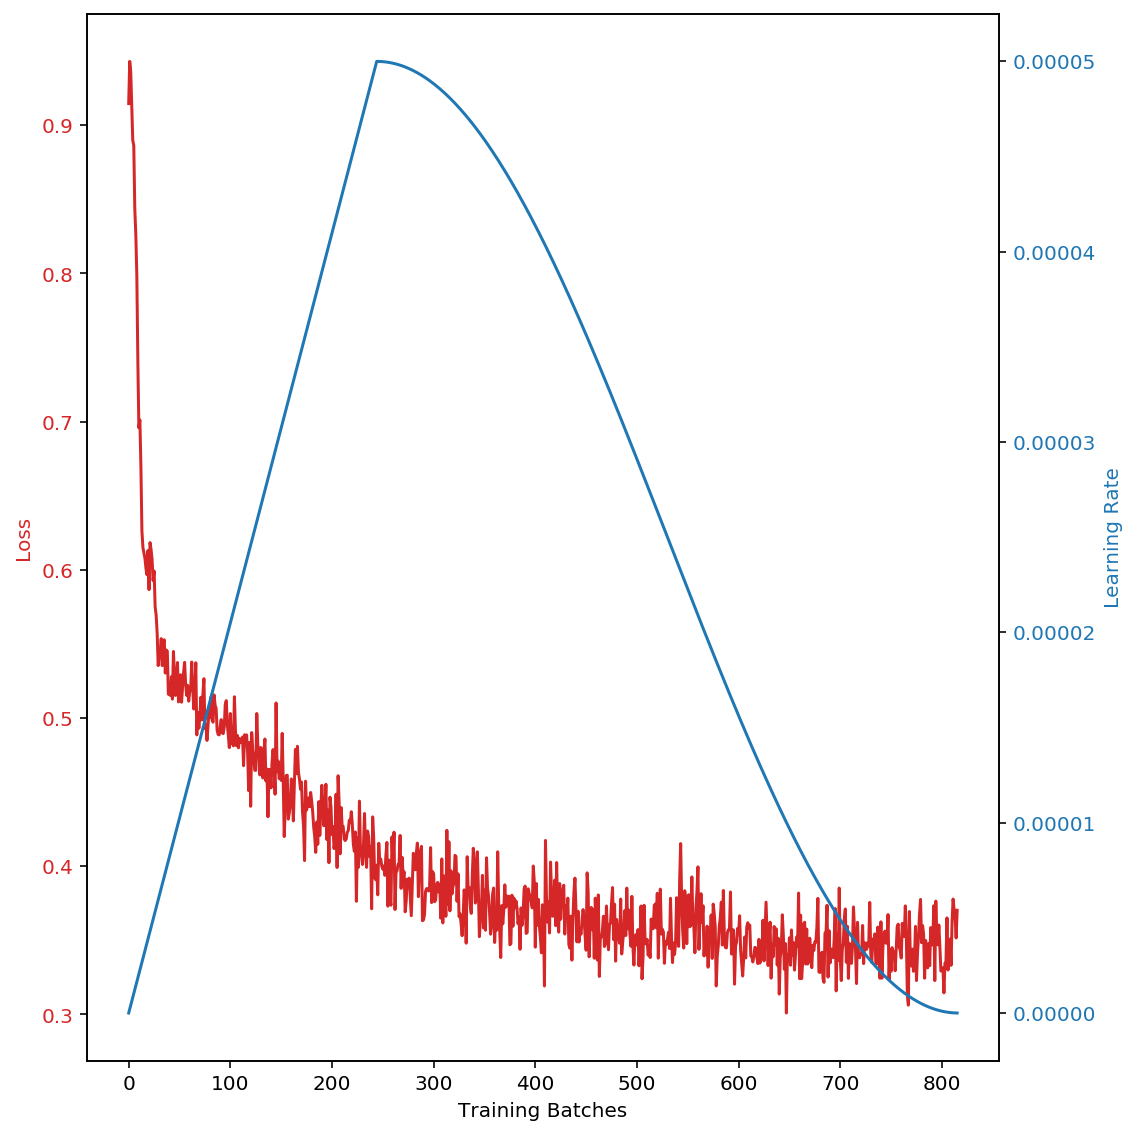

Proba       Preds    
         min   max   min max
Labels                      
0      0.061 0.836     0   1
1      0.144 0.817     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.452,"[0.547665536403656, 0.452334463596344]",0,0,0.241,"[0.7590835094451904, 0.240916445851326]",0,0,0.621,"[0.3785116374492645, 0.6214883327484131]",1,1
1,0.453,"[0.5468462109565735, 0.4531537890434265]",0,1,0.728,"[0.27241846919059753, 0.7275815010070801]",1,1,0.377,"[0.6228605508804321, 0.37713944911956787]",0,1
2,0.206,"[0.794008195400238, 0.20599175989627838]",0,1,0.755,"[0.24530857801437378, 0.7546914219856262]",1,1,0.253,"[0.7469903826713562, 0.2530095875263214]",0,1
3,0.435,"[0.5653978586196899, 0.4346020817756653]",0,0,0.652,"[0.3483525514602661, 0.6516474485397339]",1,1,0.613,"[0.3871273398399353, 0.6128726005554199]",1,1
4,0.608,"[0.3916504979133606, 0.6083495020866394]",1,1,0.481,"[0.5187690854072571, 0.4812309145927429]",0,0,0.607,"[0.3928397297859192, 0.607160210609436]",1,0


scores =  {'map': '0.6205', 'acc': '0.5680', 'auc': '0.6536'}


train   val
mean_or_std metric               
mean        map       0.783 0.620
            accuracy  0.770 0.568
            auc       0.854 0.654
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                     
    precision recall    f1  supoort precision recall    f1 supoort
neg     0.842  0.790 0.815 5450.000     0.553  0.712 0.622 250.000
pos     0.662  0.734 0.697 3050.000     0.596  0.424 0.495 250.000

In [20]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.01,
                              dropout=0.05,
                              word_masking_proba=0.1,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=48,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False,
                              n_classifier_layers=1,
                              n_classifier_decoders=16, # 4
                             ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[17, 27, 34, 41, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False
)
r2, p2 = results, prfs
results
prfs

# 0.854	0.654 x2


In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=8e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"]/2,
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"]/2,
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"]/2,
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.01,
                              dropout=0.05,
                              word_masking_proba=0.1,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=48,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False,
                              n_classifier_layers=1,
                              n_classifier_decoders=16, # 4
                             ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[17, 27, 34, 41, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False
)
r2, p2 = results, prfs
results
prfs




Pick stored Model /home/ahemf/cache/distilbert-nsp Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>
Autocast =  True Epochs =  48 Divisor = 2 Examples = 4250 Batch Size =  256
Training Samples =  8500 Weighted Sampling =  True Num Batches =  17 Accumulation steps =  1



Epoch =  1 Loss = 0.695816 LR = 0.00000279



Epoch =  2 Loss = 0.565480 LR = 0.00000557



Epoch =  3 Loss = 0.524718 LR = 0.00000836


### Train Head First

In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer_class = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "finetune": False,
    }
}

epochs = 8
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.01,
                              dropout=0.05,
                              word_masking_proba=0.1,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=48,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False,
                              n_classifier_layers=1,
                              n_classifier_decoders=16, # 4
                             ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer_class,
                         optimiser_params=optimizer_params)


model, optimizer = model_fn()
kfold = False
results, prfs = train_validate_ntimes(
    (model, optimizer),
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[15, 27, 34, 41, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False
)
r2, p2 = results, prfs
results
prfs

adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer_params = adamw_params
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

_ = group_wise_finetune(model, lr_strategy)
params_conf, _ = group_wise_lr(model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)


epochs = 24
kfold = False
results, prfs = train_validate_ntimes(
    (model, optimizer),
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[15, 21, 27, 31, 34, 41, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False
)
r2, p2 = results, prfs
results
prfs



## Multi-eval decoder ensemble

In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params


data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=None, 
                    test_text_transform=preprocess_text_test, test_image_transform=None, 
                    cache_images = True, use_images = False, dev=False, test_dev=True,
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)


lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"]/10,
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"]/10,
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"]/10,
                    "finetune": True
                }
            }
        },
    },
    "final_layer": {
        "lr": optimizer_params["lr"]
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.02,
                              dropout=0.1,
                              word_masking_proba=0.1,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=64,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.01,
                              finetune=False,
                              n_classifier_layers=1,
                              n_classifier_decoders=16, # 4
                             ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[19, 27, 37, 41, 46, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=10, evaluate_in_train_mode=True
)
r2, p2 = results, prfs
results
prfs


# Predict

In [7]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.01,
                              dropout=0.05,
                              word_masking_proba=0.1,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=48,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False,
                              n_classifier_layers=1,
                              n_classifier_decoders=16, # 4
                             ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)


Pick stored Model /home/ahemf/cache/distilbert-nsp Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>
Autocast =  True Epochs =  48 Divisor = 2 Examples = 4250 Batch Size =  256
Training Samples =  8500 Weighted Sampling =  True Num Batches =  17 Accumulation steps =  1



Epoch =  1 Loss = 0.784492 LR = 0.00000348



Epoch =  2 Loss = 0.578230 LR = 0.00000697


Exception for:  keyboard | '' '' | ['keyboard' 'char_swap'] argument of type 'NoneType' is not iterable

Epoch =  3 Loss = 0.528281 LR = 0.00001045



Epoch =  4 Loss = 0.512003 LR = 0.00001393



Epoch =  5 Loss = 0.506022 LR = 0.00001742



Epoch =  6 Loss = 0.497311 LR = 0.00002090



Epoch =  7 Loss = 0.488509 LR = 0.00002439



Epoch =  8 Loss = 0.483169 LR = 0.00002787



Epoch =  9 Loss = 0.468048 LR = 0.00003135



Epoch =  10 Loss = 0.453963 LR = 0.00003484



Epoch =  11 Loss = 0.440564 LR = 0.00003832



Epoch =  12 Loss = 0.438991 LR = 0.00004180



Epoch =  13 Loss = 0.424856 LR = 0.00004529



Epoch =  14 Loss = 0.432670 LR = 0.00004877



Epoch =  15 Loss = 0.419983 LR = 0.00004995


Proba       Preds    
         min   max   min max
Labels                      
0      0.300 0.764     0   1
1      0.348 0.760     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.488,"[0.5115839242935181, 0.48841601610183716]",0,0,0.455,"[0.5448110699653625, 0.45518893003463745]",0,1,0.407,"[0.592654287815094, 0.4073456823825836]",0,1
1,0.533,"[0.46651238203048706, 0.5334875583648682]",1,1,0.485,"[0.5147520303726196, 0.48524796962738037]",0,1,0.526,"[0.47350165247917175, 0.5264983177185059]",1,1
2,0.648,"[0.3515700399875641, 0.6484299302101135]",1,0,0.428,"[0.5720463991165161, 0.4279536306858063]",0,0,0.508,"[0.4922139644622803, 0.5077860355377197]",1,1
3,0.426,"[0.5744873285293579, 0.4255126714706421]",0,1,0.431,"[0.5686672925949097, 0.43133264780044556]",0,0,0.465,"[0.5348242521286011, 0.4651757478713989]",0,0
4,0.572,"[0.42794233560562134, 0.5720576643943787]",1,0,0.518,"[0.4822366237640381, 0.5177633762359619]",1,0,0.446,"[0.5539174675941467, 0.44608253240585327]",0,0


scores =  {'map': '0.5823', 'acc': '0.5800', 'auc': '0.5831'}
Epoch =  15 Train = 0.709907 Val = 0.583136



Epoch =  16 Loss = 0.402333 LR = 0.00004970



Epoch =  17 Loss = 0.402363 LR = 0.00004924



Epoch =  18 Loss = 0.389431 LR = 0.00004856



Epoch =  19 Loss = 0.385181 LR = 0.00004768



Epoch =  20 Loss = 0.396081 LR = 0.00004660



Epoch =  21 Loss = 0.382487 LR = 0.00004534



Epoch =  22 Loss = 0.389811 LR = 0.00004389



Epoch =  23 Loss = 0.387746 LR = 0.00004229



Epoch =  24 Loss = 0.378375 LR = 0.00004053



Epoch =  25 Loss = 0.372108 LR = 0.00003863



Epoch =  26 Loss = 0.375873 LR = 0.00003662



Epoch =  27 Loss = 0.387211 LR = 0.00003450



Epoch =  28 Loss = 0.364837 LR = 0.00003231



Epoch =  29 Loss = 0.370296 LR = 0.00003005



Epoch =  30 Loss = 0.365642 LR = 0.00002774



Epoch =  31 Loss = 0.359036 LR = 0.00002541



Epoch =  32 Loss = 0.363438 LR = 0.00002308


Exception for:  keyboard | '' '' | ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  33 Loss = 0.361333 LR = 0.00002076



Epoch =  34 Loss = 0.373662 LR = 0.00001849


Proba       Preds    
         min   max   min max
Labels                      
0      0.080 0.718     0   1
1      0.118 0.725     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.341,"[0.6593551635742188, 0.34064480662345886]",0,1,0.308,"[0.6915073990821838, 0.30849260091781616]",0,1,0.223,"[0.7771186828613281, 0.22288130223751068]",0,0
1,0.290,"[0.7097020149230957, 0.2902980148792267]",0,1,0.399,"[0.6014572381973267, 0.3985428214073181]",0,1,0.725,"[0.2745033800601959, 0.7254965901374817]",1,1
2,0.489,"[0.5106979608535767, 0.48930200934410095]",0,0,0.345,"[0.6547924280166626, 0.345207542181015]",0,1,0.288,"[0.711603045463562, 0.288396954536438]",0,0
3,0.519,"[0.4814039468765259, 0.5185960531234741]",1,1,0.325,"[0.6745779514312744, 0.3254220485687256]",0,0,0.439,"[0.5608513355255127, 0.4391486644744873]",0,1
4,0.232,"[0.7677463293075562, 0.23225365579128265]",0,0,0.314,"[0.685692548751831, 0.31430739164352417]",0,1,0.408,"[0.5922837257385254, 0.40771618485450745]",0,1


scores =  {'map': '0.5987', 'acc': '0.5300', 'auc': '0.6180'}
Epoch =  34 Train = 0.758743 Val = 0.618008



Epoch =  35 Loss = 0.364738 LR = 0.00001626


Exception for:  keyboard | ' ' | ['char_delete' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  36 Loss = 0.358344 LR = 0.00001412



Epoch =  37 Loss = 0.364073 LR = 0.00001207


Exception for:  keyboard | '' '' | ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  38 Loss = 0.350621 LR = 0.00001013



Epoch =  39 Loss = 0.355293 LR = 0.00000832



Epoch =  40 Loss = 0.354560 LR = 0.00000666



Epoch =  41 Loss = 0.355734 LR = 0.00000515



Epoch =  42 Loss = 0.354164 LR = 0.00000382


Proba       Preds    
         min   max   min max
Labels                      
0      0.042 0.715     0   1
1      0.146 0.784     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.380,"[0.619806170463562, 0.3801937997341156]",0,1,0.345,"[0.6554756164550781, 0.3445243239402771]",0,0,0.402,"[0.5977364778518677, 0.40226346254348755]",0,1
1,0.492,"[0.5084603428840637, 0.4915396273136139]",0,1,0.278,"[0.7224445343017578, 0.2775554060935974]",0,1,0.323,"[0.6769064664840698, 0.3230935335159302]",0,1
2,0.696,"[0.3040061295032501, 0.6959939002990723]",1,1,0.505,"[0.49497321248054504, 0.5050268173217773]",1,0,0.483,"[0.5171675086021423, 0.48283255100250244]",0,1
3,0.337,"[0.6630046367645264, 0.33699530363082886]",0,0,0.377,"[0.6226129531860352, 0.37738707661628723]",0,0,0.501,"[0.49857863783836365, 0.501421332359314]",1,1
4,0.349,"[0.6512951850891113, 0.3487047851085663]",0,0,0.349,"[0.6513786911964417, 0.34862130880355835]",0,1,0.484,"[0.5162875652313232, 0.48371243476867676]",0,0


scores =  {'map': '0.6239', 'acc': '0.5800', 'auc': '0.6227'}
Epoch =  42 Train = 0.751594 Val = 0.622656



Epoch =  43 Loss = 0.353245 LR = 0.00000268



Epoch =  44 Loss = 0.361072 LR = 0.00000172



Epoch =  45 Loss = 0.355963 LR = 0.00000097



Epoch =  46 Loss = 0.356084 LR = 0.00000043


Proba       Preds    
         min   max   min max
Labels                      
0      0.122 0.813     0   1
1      0.128 0.782     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.527,"[0.47347012162208557, 0.5265299081802368]",1,0,0.421,"[0.5789355039596558, 0.42106449604034424]",0,1,0.419,"[0.580538809299469, 0.4194611608982086]",0,1
1,0.517,"[0.48288002610206604, 0.5171200037002563]",1,1,0.526,"[0.47366130352020264, 0.5263386964797974]",1,0,0.731,"[0.26869407296180725, 0.7313058972358704]",1,0
2,0.391,"[0.6089872121810913, 0.39101269841194153]",0,0,0.335,"[0.665068507194519, 0.3349315822124481]",0,0,0.382,"[0.61826491355896, 0.38173508644104004]",0,1
3,0.216,"[0.783623993396759, 0.21637600660324097]",0,1,0.483,"[0.516800045967102, 0.48319992423057556]",0,0,0.416,"[0.5839285254478455, 0.41607147455215454]",0,1
4,0.573,"[0.4270639419555664, 0.5729360580444336]",1,0,0.412,"[0.5882579684257507, 0.41174203157424927]",0,1,0.306,"[0.693713903427124, 0.3062860369682312]",0,0


scores =  {'map': '0.6024', 'acc': '0.5700', 'auc': '0.6247'}
Epoch =  46 Train = 0.758121 Val = 0.624736



Epoch =  47 Loss = 0.352400 LR = 0.00000011



Epoch =  48 Loss = 0.350302 LR = 0.00000000



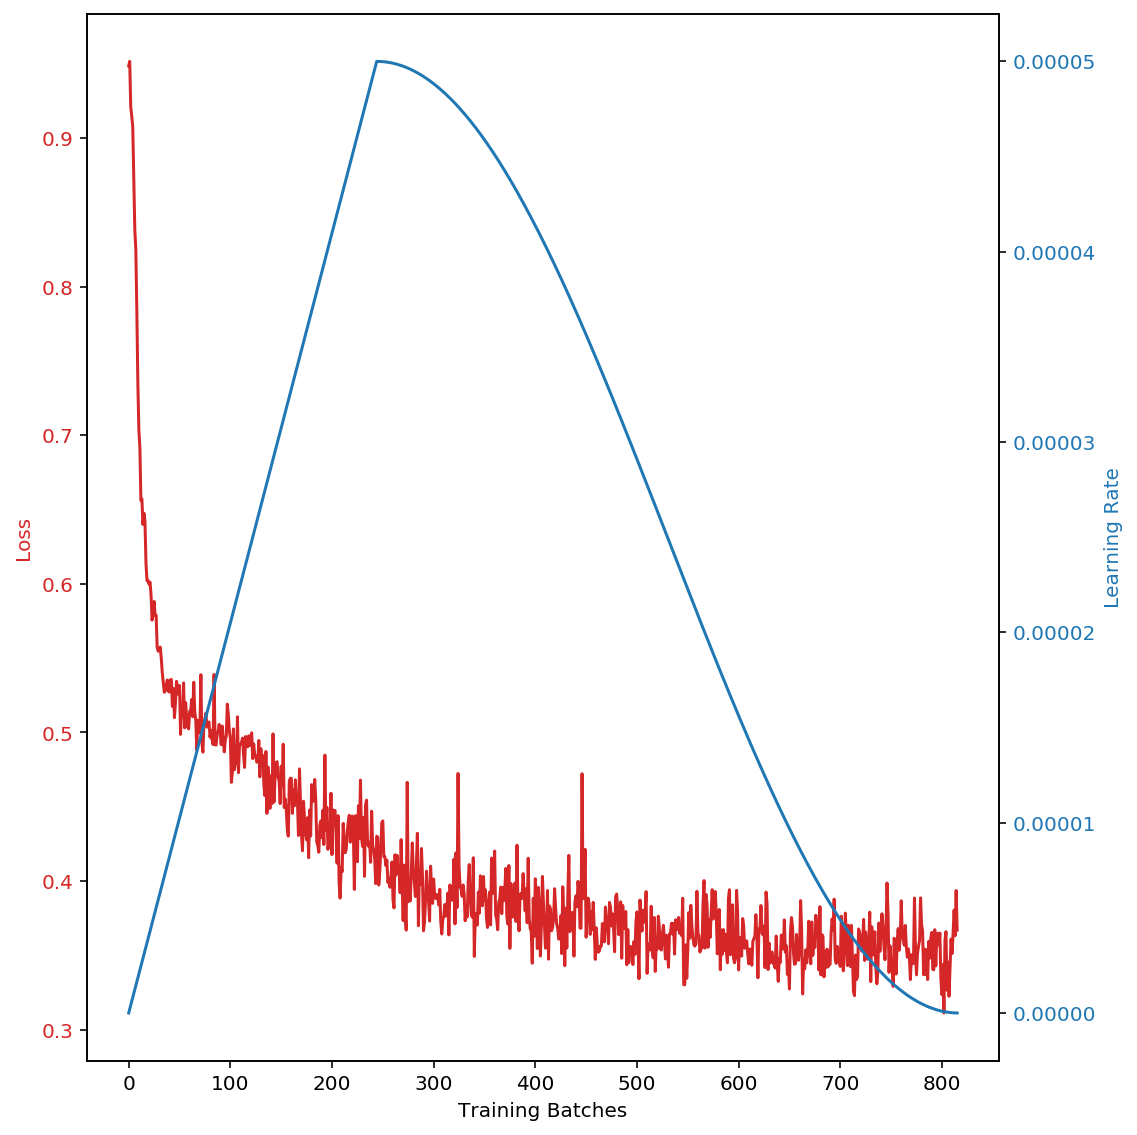

,id,proba,label
776,63097,0.299,0
992,31405,0.611,1
307,4239,0.281,0
946,59401,0.484,0
501,21659,0.434,0


In [8]:
submission, text_model = train_and_predict(model_fn, data, batch_size, epochs, 
                                           scheduler_init_fn=scheduler_init_fn, 
                                           model_call_back=reg_sched,
                                           sampling_policy="without_replacement",
                                           validation_epochs=[15, 34, 42, 46],
                                          )
submission.to_csv("submission.csv",index=False)
submission.sample(5)
